<a href="https://colab.research.google.com/github/KaustubhKhulbe/RoboticsMath/blob/main/Differential_Drive_Trajectory_Optimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
import numpy as np
import matplotlib.pyplot as plt

In [13]:
try:
  import pydrake
  import underactuated
except ImportError:
  !curl -s https://raw.githubusercontent.com/RussTedrake/underactuated/master/scripts/setup/jupyter_setup.py > jupyter_setup.py
  from jupyter_setup import setup_underactuated
  setup_underactuated()

Constants:

`m` - mass of robot

`I` - moment of inertia of robot

`r_bot` - radius of bot (width between wheels / 2)

`r_wheel` - radius of wheel

`k_emf` - emf constant of motor (must take into account gear ratio)

`k_magnet` - constant of magnet (must take into account gear ratio)

Input vector:

$ \mathbf{u} = \begin{bmatrix}
V_L \\
V_R
\end{bmatrix} $

State vector:

$ \mathbf{x} = \begin{bmatrix}
x \\ 
y \\
\theta \\
v \\
\omega \\
\end{bmatrix} $


$f(x, u)$ returns the derivative of x based on the input voltages

$f(x, u) = \mathbf{\dot{x}} = \begin{bmatrix} \dot{x} \\ \dot{y} \\ \dot{\theta}\\ \dot{v} \\ \dot{\omega} \end{bmatrix} = \begin{bmatrix} v*cos(\theta) \\ v*sin(\theta) \\ \omega \\ (\tau(V_r) + \tau(V_l)) / (r * r_{wheel} * m) \\ r_{wheelbase} * (\tau(V_r) - \tau(V_l)) / r_{wheel} \end{bmatrix}$

In [14]:
from pydrake.all import eq, le, ge, MathematicalProgram, Solve, Variable

m = 55.
I = 1.
r_bot = 0.5
r_wheel = 0.2

k_emf = 2.
k_magnet = 2.

`model` is $f(x, u)$

`getWheelVelocity` - returns the angular velocity of wheel (need to clarify which wheel it is)

`getWheelTorque` - returns the motor torque of the wheel using `V` (voltage applied) and `vf` (surface velocity of wheel)

In [15]:
def model(x, u): #state and input vector: f(x, u)
  v = x[3]
  left_wheel_torque = getWheelTorque(u[0], getWheelVelocity(v, x[4], False))
  right_wheel_torque = getWheelTorque(u[1], getWheelVelocity(v, x[4], True))
  dx = np.array([
    v * np.cos(x[2] + 0.),
    v * np.sin(x[2] + 0.),
    x[4],
    (left_wheel_torque + right_wheel_torque) / (r_wheel * m),
    r_bot * (right_wheel_torque - left_wheel_torque) / (r_wheel * I)
  ])

  return dx

def getWheelVelocity(v, w, direction):
  if direction:
    return (v + r_bot * w) / r_wheel
  return (v - r_bot * w) / r_wheel

def getWheelTorque(V, vf):
  voltage_eff = V - k_emf * vf #since vf is wheel speed, k_emf needs to account for the gearing. same for k_magnet
  return k_magnet * voltage_eff


This is just a test to make sure that the above code works. It is assuming the start state is stationary and that the voltage applied is constant.

In this example, left motor is applying 12V and right motor is applying 6V which, intuitively, makes the robot travel in a circle

In [16]:
x = np.array([0., 0., 0., 0., 0.])
u_const = np.array([12., 6.])

output_x = []
output_y = []

time = []
for i in range(0, 1000):
  time.append(0.01)

for i in time:
  x = x + model(x, u_const) * 0.01
  ans = [x[0], x[1]]
  output_x.append(ans[0])
  output_y.append(ans[1])


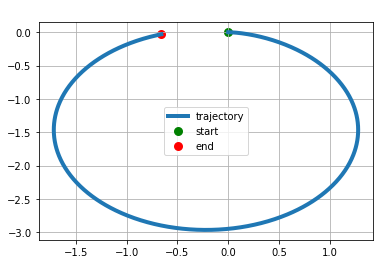

In [17]:
plt.plot(output_x, output_y, linewidth=4, label='trajectory')
plt.scatter(output_x[0], output_y[0], c='green', label='start', linewidth=3)
plt.scatter(output_x[len(output_x) - 1], output_y[len(output_y) - 1], c='red', label='end', linewidth=3)
plt.title('Test of Trajectory', c='white')

plt.grid()
plt.legend()

`waypoints` - list of points we want the robot to go to. These are the state variables discussed above

In [18]:
'''waypoints = np.array([
    np.array([np.array([0, 0, np.pi/2, 0, 0]), 0]),
    np.array([np.array([5, 3, np.pi, 0, 0]), 100]),
    np.array([np.array([8, 7, np.pi, 0, 0]), 300])
])'''

waypoints = np.array([
    np.array([np.array([0, 5, 0, 0, 0]), 0]),
    np.array([np.array([2, 4, 0, 3, 0]), 100]),
    np.array([np.array([6, 6, 0, 0, 0]), 200])
])



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when c

`solve` is the actual function which sets everything up and solves for the optimum solution


`N` - is the number of intervals

`T` - is the time per interval (we use this since we do linear approximation)

`u` - empty list in which we will put every value in

`x` - same as `u` except it's for all the state variables


In [19]:
def solve():

  N = waypoints[-1, 1] + 1
  T = 0.05 #Frequency robot runs at
  prog = MathematicalProgram()

  u = np.empty((2, N-1), dtype=Variable)
  x = np.empty((5, N), dtype=Variable)

  for n in range(N-1):
    u[:,n] = prog.NewContinuousVariables(2, 'u' + str(n))
    x[:,n] = prog.NewContinuousVariables(5, 'x' + str(n))

    prog.SetInitialGuess(u[:,n], np.zeros_like(u[:,n]))
    prog.SetInitialGuess(x[:,n], np.zeros_like(x[:,n]))
  x[:,N-1] = prog.NewContinuousVariables(5, 'x' + str(N))

  prog.AddBoundingBoxConstraint(waypoints[0][0], waypoints[0][0], x[:,waypoints[0][1]])

  for n in range(0, N-1):
    #prog.AddQuadraticCost(u[:,n].dot(u[:,n]))  #Minimize input error
    prog.AddConstraint(eq(x[:,n+1], x[:,n]+model(x[:,n], u[:,n])*T))
    prog.AddBoundingBoxConstraint(-12, 12, u[:,n]) 

    v = x[3,n]
    torque = np.array([getWheelTorque(u[0,n], getWheelVelocity(x[3,n], x[4,n], False)), getWheelTorque(u[1,n], getWheelVelocity(x[3,n], x[4,n], True))])
    prog.AddQuadraticCost(torque.dot(torque))

  for w in range(len(waypoints)):

    w_ts = waypoints[w][1] #waypoints time stamp
    w_at_w = waypoints[w][0] #waypoint at w

    dot_expression = x[:, w_ts] - w_at_w

    prog.AddQuadraticCost(100*(dot_expression.dot(dot_expression))) #minimize waypoint error

  
    
  result = Solve(prog)

  x_sol = result.GetSolution(x)
  u_sol = result.GetSolution(u)

  assert(result.is_success()), "Optimization failed"

  return x_sol, u_sol, N

  print(x_sol)
  print(u_sol)

In [20]:
x_sol, u_sol, N = solve()

Here we are splitting `x_sol` into it's x and y parts (note: it has more information but for a graph, this is enough)

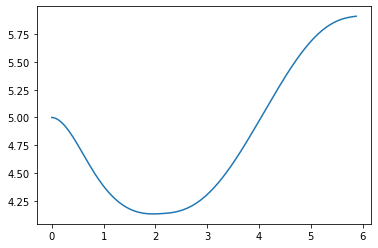

In [21]:
x_coords = []
y_coords = []

for i in range(N):
  x_coords.append(x_sol[0,i])
  y_coords.append(x_sol[1,i])
#print(x_coords)
#print(y_coords)

#print(u_sol)
plt.plot(x_coords, y_coords)

This is doing the same thing but now for `u_sols`. It graphs the voltage each motor needs to apply at each time interval

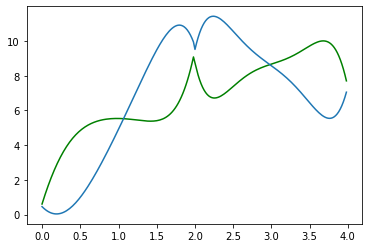

In [22]:
left = []
right = []

for i in range(N-1):
  left.append(u_sol[0, i])
  right.append(u_sol[1, i])

time = []
for i in range(N-1):
  time.append(i * 0.02)

plt.plot(time, left, c='green')
plt.plot(time, right)

